In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import scipy
from scipy import sparse as sp
from scipy.sparse import coo_matrix,spdiags,csr_matrix

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Inferring ranks and group preferences


$$ H^{++} = H(s, \theta) + \tfrac{1}{2} \lambda_s ||s||_2^2 + \tfrac{1}{2} \lambda_{\theta} ||\theta||_2^2 $$

Want to solve:
$$\begin{align}
\nabla H^{++} &= 0 \\
\implies \nabla_s : \nabla_s H + \lambda_s s &= 0, \\
\nabla_{\theta} : \nabla_{\theta} H + \lambda_{\theta} \theta &= 0
\end{align}$$

Define:
$$\begin{align}
\Lambda_s &= \lambda_s I_{N} \\
\Lambda_{\theta} &= \lambda_{\theta} I_{k}
\end{align}$$

So, solve:
$$
\begin{bmatrix}
L + \Lambda_s & LG \\
G^T L & G^T LG + \Lambda_{\theta}
\end{bmatrix} \begin{bmatrix}
s \\
\theta \\
\end{bmatrix} = \begin{bmatrix}
\hat{d} \\
G^{T} \hat{d}
\end{bmatrix}
$$

In [191]:
N = 600
num_groups = {
              "cat_01" : 4,
             }
l0 = {
      "individual": 0,
      "cat_01": 0,
     }
alpha = {
         "individual": 1,
         "cat_01": 1,
        }

beta = 0.4
print("Variance", 1 / beta)
p_ij = 1 / (1 + np.exp(-2*beta))
K = 10

A, G, scores, ranks = sr.SpringRank_planted_network_groups(
                            N, num_groups, beta, alpha, K, np.random, l0, l1=1,
                            allow_self_loops=False, return_ranks=True)

A = np.array(nx.to_numpy_matrix(A))
G = G["cat_01"]

group_keys = G.nonzero()[1]

a = scores["individual"] - np.min(scores["individual"])
theta = scores["cat_01"] - np.min(scores["cat_01"])
s = a + np.matmul(G, theta)

Variance 2.5


In [192]:
ranks_est, scores_est = sr.SpringRank_groups(A,
                                             {"cat_01": G},
                                             {"individual": 1e-5, "cat_01": 0},
                                             solver="bicgstab")

a_est = tl.adjust_ranks(scores_est["individual"], A, p_ij=p_ij)
beta_hat = tl.get_temperature(scores_est["individual"], A, p_ij=p_ij)

theta_est = beta_hat * (scores_est["cat_01"] - np.min(scores_est["cat_01"]))
s_est = a_est + np.matmul(G, theta_est)

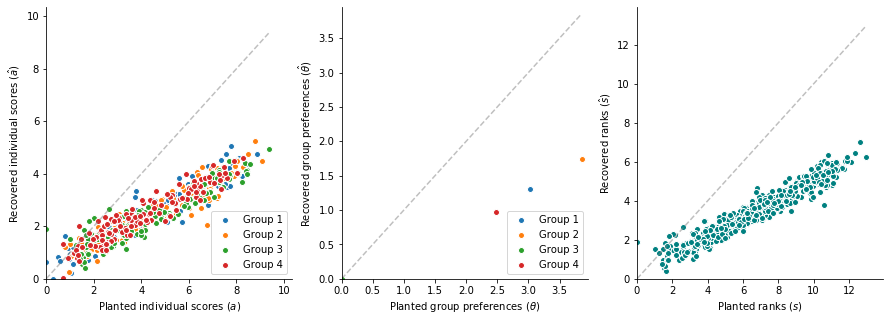

In [193]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x_y_line = [[0, np.max(np.maximum(a, a_est))],
            [0, np.max(np.maximum(theta, theta_est))],
            [0, np.max(np.maximum(s, s_est))]]

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].plot(x_y_line[i], x_y_line[i], linestyle="dashed", color="grey", alpha=0.5)
    ax[i].set_xlim(0, x_y_line[i][1]+1)
    ax[i].set_ylim(0, x_y_line[i][1]+1)

for i in range(4):
    idx = np.where(group_keys==i)
    ax[0].scatter(a[idx], a_est[idx],
                  edgecolor="white",
                  label="Group {}".format(i+1))
    ax[1].scatter(theta[i], theta_est[i],
                  edgecolor="white",
                  label="Group {}".format(i+1))


ax[0].set_xlabel(r"Planted individual scores ($a$)")
ax[0].set_ylabel(r"Recovered individual scores ($\hat{a}$)")
ax[0].legend(loc="lower right")

ax[1].set_xlabel(r"Planted group preferences ($\theta$)")
ax[1].set_ylabel(r"Recovered group preferences ($\hat{\theta}$)")
ax[1].legend(loc="lower right")
ax[1].set_xlim(0, x_y_line[1][1]+0.1)
ax[1].set_ylim(0, x_y_line[1][1]+0.1)

ax[2].scatter(s, s_est, color="teal", edgecolor="white",)
ax[2].set_xlabel(r"Planted ranks ($s$)")
ax[2].set_ylabel(r"Recovered ranks ($\hat{s}$)")

plt.savefig("../../figures/Test2_B_SR.PNG", dpi=200, bbox_inches="tight")

plt.show()

Everyone is created equal, on average

In [194]:
a_mean = np.matmul(G.T, a_est) / np.sum(G.T, axis=1) # average a across all groups
a_t = a_est - np.matmul(G, a_mean) # shift so all of the a's have the same mean = 0
theta_t = theta_est + a_mean # we also need to shift the theta's

s_t = a_t + np.matmul(G, theta_t)

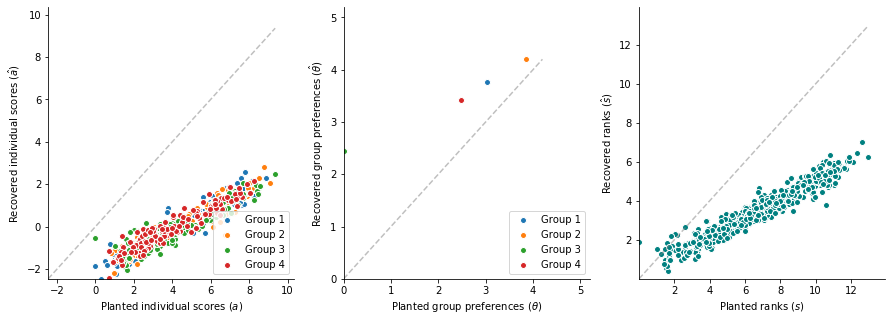

In [195]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x_y_line = [[np.min(np.minimum(a, a_t)), np.max(np.maximum(a, a_t))],
            [np.min(np.minimum(theta, theta_t)), np.max(np.maximum(theta, theta_t))],
            [np.min(np.minimum(s, s_t)), np.max(np.maximum(s, s_t))]]

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].plot(x_y_line[i], x_y_line[i], linestyle="dashed", color="grey", alpha=0.5)
    ax[i].set_xlim(x_y_line[i][0], x_y_line[i][1]+1)
    ax[i].set_ylim(x_y_line[i][0], x_y_line[i][1]+1)

for i in range(4):
    idx = np.where(group_keys==i)
    ax[0].scatter(a[idx], a_t[idx],
                  edgecolor="white",
                  label="Group {}".format(i+1))
    ax[1].scatter(theta[i], theta_t[i],
                  edgecolor="white",
                  label="Group {}".format(i+1))


ax[0].set_xlabel(r"Planted individual scores ($a$)")
ax[0].set_ylabel(r"Recovered individual scores ($\hat{a}$)")
ax[0].legend(loc="lower right")

ax[1].set_xlabel(r"Planted group preferences ($\theta$)")
ax[1].set_ylabel(r"Recovered group preferences ($\hat{\theta}$)")
ax[1].legend(loc="lower right")

ax[2].scatter(s, s_t, color="teal", edgecolor="white",)
ax[2].set_xlabel(r"Planted ranks ($s$)")
ax[2].set_ylabel(r"Recovered ranks ($\hat{s}$)")


plt.savefig("../../figures/Test2_B_shifted.PNG", dpi=200, bbox_inches="tight")

plt.show()

"Hijacked"

In [164]:
a_hijacked = a_mean + np.array([10, -10, 0, 5])
a_h = a_est - np.matmul(G, a_hijacked) # shift so all of the a's have the same mean = 0
theta_h = theta_est + a_hijacked # we also need to shift the theta's

s_h = a_h + np.matmul(G, theta_h)

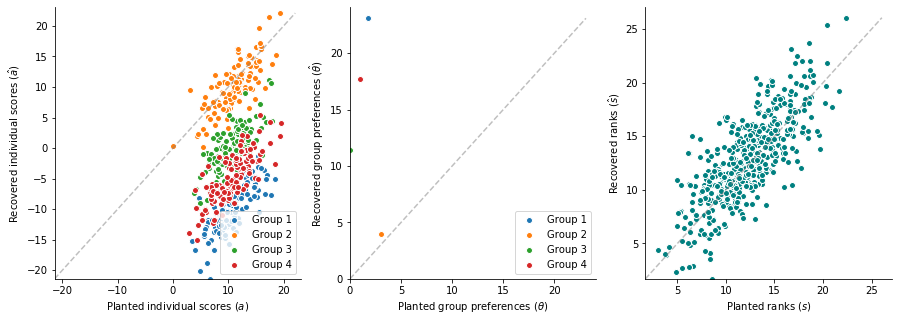

In [166]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x_y_line = [[np.min(np.minimum(a, a_h)), np.max(np.maximum(a, a_h))],
            [np.min(np.minimum(theta, theta_h)), np.max(np.maximum(theta, theta_h))],
            [np.min(np.minimum(s, s_h)), np.max(np.maximum(s, s_h))]]

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].plot(x_y_line[i], x_y_line[i], linestyle="dashed", color="grey", alpha=0.5)
    ax[i].set_xlim(x_y_line[i][0], x_y_line[i][1]+1)
    ax[i].set_ylim(x_y_line[i][0], x_y_line[i][1]+1)

for i in range(4):
    idx = np.where(group_keys==i)
    ax[0].scatter(a[idx], a_h[idx],
                  edgecolor="white",
                  label="Group {}".format(i+1))
    ax[1].scatter(theta[i], theta_h[i],
                  edgecolor="white",
                  label="Group {}".format(i+1))


ax[0].set_xlabel(r"Planted individual scores ($a$)")
ax[0].set_ylabel(r"Recovered individual scores ($\hat{a}$)")
ax[0].legend(loc="lower right")

ax[1].set_xlabel(r"Planted group preferences ($\theta$)")
ax[1].set_ylabel(r"Recovered group preferences ($\hat{\theta}$)")
ax[1].legend(loc="lower right")

ax[2].scatter(s, s_h, color="teal", edgecolor="white",)
ax[2].set_xlabel(r"Planted ranks ($s$)")
ax[2].set_ylabel(r"Recovered ranks ($\hat{s}$)")

plt.savefig("../../figures/Test1_A_non-identifiable.PNG", dpi=200, bbox_inches="tight")

plt.show()

## Faculty Hiring

In [2]:
CS_adjacency_matrix = np.load("../../data/CS.npy")[:-1, :-1]
regions_list = np.load("../../data/CS_regions.npy")
regions_keys = np.load("../../data/CS_regions_key.npy", allow_pickle=True)

clean_regions_idx = []
clean_regions_list = []
for idx, x in enumerate(regions_list):
    if x != 1:
        clean_regions_idx.append(idx)
        if x > 1:
            clean_regions_list.append(x-1)
        else:
            clean_regions_list.append(x)

clean_regions_list = np.array(clean_regions_list)
CS_clean = CS_adjacency_matrix[clean_regions_idx][:, clean_regions_idx]

In [3]:
G_regions = np.zeros((CS_adjacency_matrix.shape[0], np.max(regions_list)+1))
for i in range(len(regions_list)):
    G_regions[i, regions_list[i]] = 1
    
    
# clean
clean_regions_keys = list(regions_keys[:1]) + list(regions_keys[2:])

G_clean = np.zeros((CS_clean.shape[0], len(clean_regions_keys)))
for i in range(len(clean_regions_list)):
    regions_idx = clean_regions_list[i]
    G_clean[i, regions_idx] = 1

In [4]:
G = {"regions": G_clean}
reg_coeff = {
             "individual": 1e-1,
             "regions": 1e-1,
            }

ranks_est, scores_est = sr.SpringRank_groups(CS_clean, G, reg_coeff, solver="bicgstab")

In [5]:
a = scores_est["individual"]
theta = scores_est["regions"]

a_mean = np.matmul(G_clean.T, a) / np.sum(G_clean.T, axis=1) # average a across all groups
a = a - np.matmul(G_clean, a_mean) # shift so all of the a's have the same mean = 0
theta = theta + a_mean # we also need to shift the theta's

s = a + np.matmul(G_clean, theta)

In [110]:
np.sum(G_clean.T, axis=1)

array([22., 38., 45., 60., 40.])

In [8]:
np.sum(CS_clean)

4388.0

In [6]:
for region, rank in zip(clean_regions_keys, theta):
    print(region, rank)

Canada    -0.11627614169199711
Midwest   0.021793635194146756
Northeast 0.24004341916168478
South     -0.1790683253204608
West      0.03207586648355179


<Figure size 432x360 with 0 Axes>

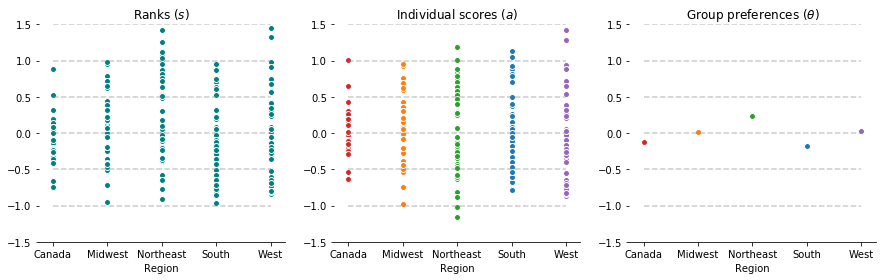

In [7]:
colors = ["tab:red", "tab:orange", "tab:green", "tab:blue", "tab:purple"]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    
    ax[i].plot([0, 4], [1.5, 1.5], linestyle="dashed", color="grey", alpha=0.4)
    ax[i].plot([0, 4], [1, 1], linestyle="dashed", color="grey", alpha=0.4)
    ax[i].plot([0, 4], [0.5, 0.5], linestyle="dashed", color="grey", alpha=0.4)
    ax[i].plot([0, 4], [0, 0], linestyle="dashed", color="grey", alpha=0.4)
    ax[i].plot([0, 4], [-0.5, -0.5], linestyle="dashed", color="grey", alpha=0.4)
    ax[i].plot([0, 4], [-1, -1], linestyle="dashed", color="grey", alpha=0.4)
    
    ax[i].set_ylim([-1.5, 1.5])
    
    ax[i].set_xlabel("Region")
    ax[i].set_xticks([0, 1, 2, 3, 4])
    ax[i].set_xticklabels([region.strip() for region in clean_regions_keys])

ax[0].scatter(clean_regions_list, s, color="teal", edgecolor="white")
ax[0].set_title(r"Ranks ($s$)")

for i in range(5):
    idx = np.where(clean_regions_list==i)
    ax[1].scatter(clean_regions_list[idx], a[idx], color=colors[i], edgecolor="white")
    ax[2].scatter(i, theta[i], color=colors[i], edgecolor="white")
    
ax[1].set_title(r"Individual scores ($a$)")

ax[2].set_title(r"Group preferences ($\theta$)")

plt.savefig("../../figures/faculty_hiring.PNG", dpi=200, bbox_inches="tight")

plt.show()